## Individual analysis of Enrolment Data

In [7]:
import os
from glob import glob
import pandas as pd

In [2]:
BASE_PATH = 'data'
enrol_path = os.path.join(BASE_PATH, 'enrolment')

In [8]:
def load_folder(folder_path):
    files = glob(os.path.join(folder_path, "*.csv"))
    print(f"Found {len(files)} files in {folder_path}")
    
    df_list = []
    for f in files:
        temp = pd.read_csv(f)
        df_list.append(temp)
    
    return pd.concat(df_list, ignore_index=True)


In [10]:
enrol_df = load_folder(enrol_path)
print(f"Enrolment DataFrame shape: {enrol_df.shape}")

enrol_df.to_csv('enrolment_data.csv', index=False)

Found 3 files in data\enrolment
Enrolment DataFrame shape: (1006029, 7)


In [14]:
%pip install scikit-learn

     ---------------------------------------- 8.1/8.1 MB 13.2 MB/s eta 0:00:00
     --------------------------------------- 36.4/36.4 MB 12.1 MB/s eta 0:00:00
     ------------------------------------- 309.1/309.1 kB 19.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import metrics  

In [16]:
enrolment_df = pd.read_csv('enrolment_data.csv')

print(enrolment_df.describe())

            pincode       age_0_5      age_5_17  age_18_greater
count  1.006029e+06  1.006029e+06  1.006029e+06    1.006029e+06
mean   5.186415e+05  3.525709e+00  1.710074e+00    1.673441e-01
std    2.056360e+05  1.753851e+01  1.436963e+01    3.220525e+00
min    1.000000e+05  0.000000e+00  0.000000e+00    0.000000e+00
25%    3.636410e+05  1.000000e+00  0.000000e+00    0.000000e+00
50%    5.174170e+05  2.000000e+00  0.000000e+00    0.000000e+00
75%    7.001040e+05  3.000000e+00  1.000000e+00    0.000000e+00
max    8.554560e+05  2.688000e+03  1.812000e+03    8.550000e+02


In [18]:
enrolment_df["total_enrolment"] = (
    enrolment_df["age_0_5"] +
    enrolment_df["age_5_17"] +
    enrolment_df["age_18_greater"]
)

In [19]:

total_enrol = enrolment_df['total_enrolment'].sum()  # From your derived
age_dist = enrolment_df[['age_0_5', 'age_5_17', 'age_18_greater']].sum() / total_enrol
print("Age Distribution:\n", age_dist)

Age Distribution:
 age_0_5           0.652531
age_5_17          0.316497
age_18_greater    0.030972
dtype: float64


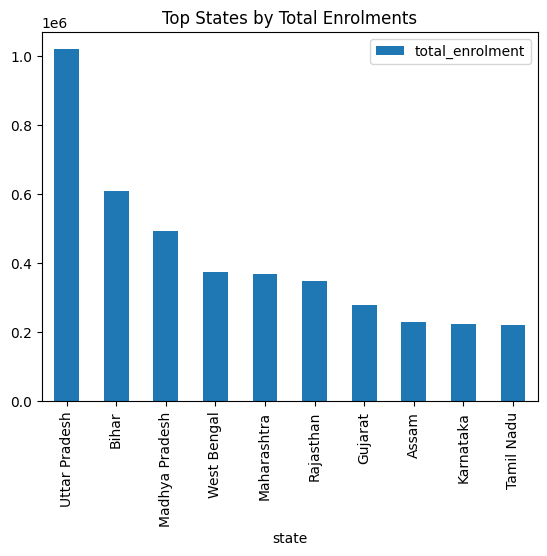

In [20]:
# Aggregate by state
state_enrol = enrolment_df.groupby('state').agg({
    'total_enrolment': 'sum',
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum'
}).reset_index()

# Viz: Top 10 states by enrolment
state_enrol.sort_values('total_enrolment', ascending=False).head(10).plot(kind='bar', x='state', y='total_enrolment')
plt.title('Top States by Total Enrolments')
plt.show()

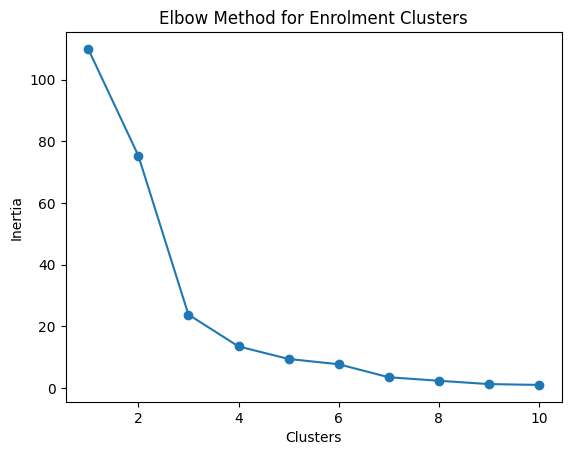

In [22]:
# Clustering prep: Features like age ratios
state_enrol['child_ratio'] = (state_enrol['age_0_5'] + state_enrol['age_5_17']) / state_enrol['total_enrolment']
features = state_enrol[['total_enrolment', 'child_ratio']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Elbow method for optimal k
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)
plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method for Enrolment Clusters')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.show()  

# Run K-Means (assume k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
state_enrol['cluster'] = kmeans.fit_predict(scaled_features)
#print(state_enrol.groupby('cluster').mean())  

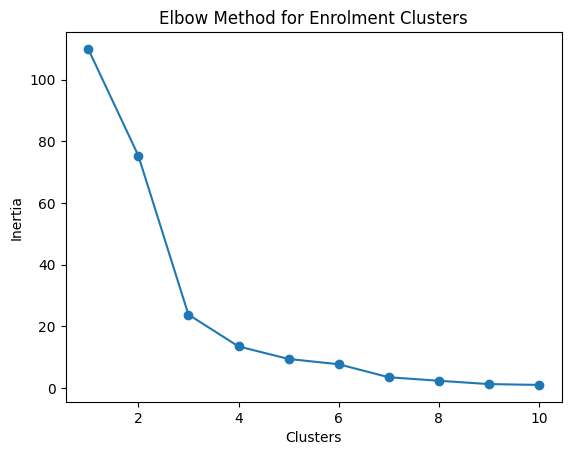

In [24]:
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)
plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method for Enrolment Clusters')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.show()  

# Run K-Means (assume k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
state_enrol['cluster'] = kmeans.fit_predict(scaled_features)  

- Based on histogram-
1. Uttar Pradesh dominates massively with 21-22+ crore live Aadhars in recent reports.
2. Bihar ranks very high in total enrolments with around 11-12 crore enrolments
3. Enrolment volume is overwhelmingly driven by population size rather than any special campaign/effort, the top 5–6 states alone likely account for 50–60%+ of all new enrolments in your dataset period.
4. UIDAI should continue prioritizing massive-scale enrolment drives, training, and mobile units in UP, Bihar, MP, WB, Maharashtra, and Rajasthan. These states generate the bulk of workload.

- Based on the elbow method-
1. The data has clear hierarchical structure — a few mega-states drive most activity, then a mid-tier, then the rest.
2. This clustering supports targeted resource allocation — e.g., Cluster 1 states need disproportionate focus on enrolment infrastructure, while lower clusters may need saturation pushes for remaining uncovered population

### Analysis by Day of the Month

<Axes: title={'center': 'Enrolments by Day of Month'}, xlabel='day_of_month'>

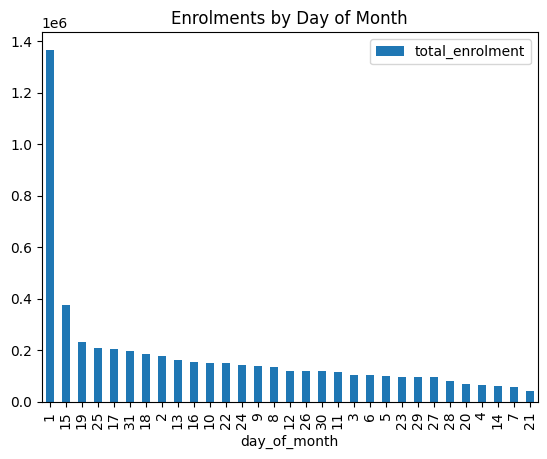

In [26]:
enrolment_df['date'] = pd.to_datetime(enrolment_df['date'], format='%d-%m-%Y')
enrolment_df['day_of_month'] = enrolment_df['date'].dt.day
day_enrol = enrolment_df.groupby('day_of_month')['total_enrolment'].sum().reset_index().sort_values('total_enrolment', ascending=False)
day_enrol.plot(kind='bar', x='day_of_month', y='total_enrolment', title='Enrolments by Day of Month')

Enrolments show a pronounced skew toward the beginning of the month, with a sharp decline thereafter.

- **Peak Day**: Day 1 stands out with the highest enrolments , nearly 3–4 times higher than mid-month days.  
- **Trend**: Activity drops rapidly by Day 15  and continues to taper off toward the end, with minor fluctuations possibly due to weekends or holidays.  
- **Interpretation**: This "first-day rush" may correlate with monthly administrative deadlines, such as government scheme registrations, salary disbursements, or school enrolment drives that align with calendar months. In high-population states like Uttar Pradesh and Maharashtra, this could strain centres if not anticipated.

<Axes: title={'center': 'Enrolments by Month'}, xlabel='month'>

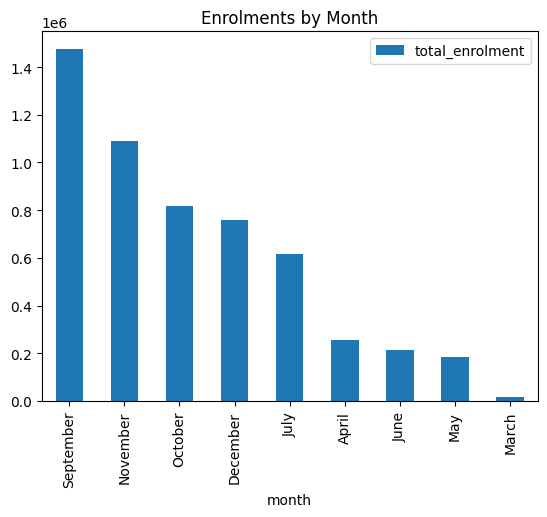

In [27]:
enrolment_df['month'] = enrolment_df['date'].dt.month_name()
month_enrol = enrolment_df.groupby('month')['total_enrolment'].sum().reset_index().sort_values('total_enrolment', ascending=False)
month_enrol.plot(kind='bar', x='month', y='total_enrolment', title='Enrolments by Month')

- **Interpretation**: September's dominance suggests a "back-to-school" effect, especially for child enrolments (age 0–17 buckets), combined with post-harvest migration in agrarian states. Lower spring months (March–May) may reflect exam seasons or heat-related disruptions.

<Axes: title={'center': 'Enrolments by Season'}, xlabel='season'>

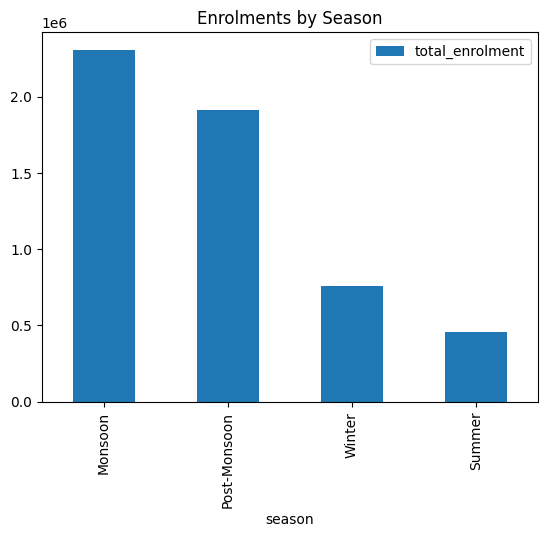

In [28]:
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Summer'
    elif month in [6, 7, 8, 9]: return 'Monsoon'
    else: return 'Post-Monsoon'

enrolment_df['month_num'] = enrolment_df['date'].dt.month
enrolment_df['season'] = enrolment_df['month_num'].apply(get_season)
season_enrol = enrolment_df.groupby('season')['total_enrolment'].sum().reset_index().sort_values('total_enrolment', ascending=False)
season_enrol.plot(kind='bar', x='season', y='total_enrolment', title='Enrolments by Season')

- **Interpretation**: Monsoon's high (~45% of total) defies typical weather-related dips, possibly due to indoor school-based campaigns or mandatory child enrolments at age milestones (e.g., 5 years). Post-monsoon follows closely, driven by festivals and economic restarts.